# Liverpool versus Manchester Restaurant War
## 1.  Create Dataframes from Wikipedia Table for Liverpool and Manchester



In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import requests


import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

!pip install folium
import folium

!pip install geocoder==1.5.0
import geocoder

import json
from pandas.io.json import json_normalize

from bs4 import BeautifulSoup



#### 1a.  Create Liverpool Dataframe

In [2]:
#Use Beautiful Soup to Evaluate HTML Code to Create Table

Liv_Website_URL=requests.get('https://en.wikipedia.org/wiki/L_postcode_area').text
SoupLiv=BeautifulSoup(Liv_Website_URL,'lxml')

#print(SoupLiv.prettify())  Command was used to find Table Link
Liverpool_Table=SoupLiv.find('table',{'class': 'wikitable sortable'})

In [3]:
Liv_DF=[]

#Create Dataframe for Imported Wikipedia Table
for row in Liverpool_Table.find_all('tr'):
        cells=row.findChildren(recursive=False)
        row_text = []
        for child in cells:
            row_text.append(child.text)
        Liv_DF.append(row_text)
            
Liverpool_DF=pd.DataFrame(Liv_DF, columns=['Postcode District', 'Post Town', 'Neighborhoods', 'Local Authority Area'])
Liverpool_DF=Liverpool_DF.replace('\n','', regex=True)

#Delete Non-Geographic Postcodes, i.e. HM Revenue and Customs and columns with Errors
NotGeographic=Liverpool_DF[Liverpool_DF['Local Authority Area']=='non-geographic'].index
Liverpool_DF.drop(NotGeographic, inplace=True)
NotGeographic2=Liverpool_DF[Liverpool_DF['Local Authority Area']=='non-geographic[5]'].index
Liverpool_DF.drop(NotGeographic2, inplace=True)
NotAssigned=Liverpool_DF[Liverpool_DF['Postcode District']=='LIVERPOOL'].index
Liverpool_DF.drop(NotAssigned, inplace=True)

#Drop Columns Not Needed for Analysis, Fix Row which Imported with Error
Liverpool_DF.drop(columns='Local Authority Area', inplace=True)
Liverpool_DF.drop(columns='Post Town', inplace=True)
Liverpool_DF.drop(0, inplace=True)
Liverpool_DF.at[20,'Neighborhoods']='Bootle, Orrell, Kirkdale'

Liverpool_DF.reset_index(drop=True, inplace=True)
Liverpool_DF.head()


,Postcode District,Neighborhoods
0,L1,City Centre
1,L2,City Centre
2,L3,"City Centre, Everton, Vauxhall"
3,L4,"Anfield, Kirkdale, Walton"
4,L5,"Anfield, Everton, Kirkdale, Vauxhall"


In [4]:
Liverpool_DF.shape

(40, 2)

#### 1b.  Create Manchester Dataframe

In [5]:
#Use Beautiful Soup to Evaluate HTML Code to Create Table

Manc_Website_URL=requests.get('https://en.wikipedia.org/wiki/M_postcode_area').text
SoupManc=BeautifulSoup(Manc_Website_URL,'lxml')

#print(SoupLiv.prettify())  Command was used to find Table Link
Manchester_Table=SoupManc.find('table',{'class': 'wikitable sortable'})

In [6]:
Manc_DF=[]

#Create Dataframe for Imported Wikipedia Table
for row in Manchester_Table.find_all('tr'):
        cells=row.findChildren(recursive=False)
        row_text = []
        for child in cells:
            row_text.append(child.text)
        Manc_DF.append(row_text)
            
Manchester_DF=pd.DataFrame(Manc_DF, columns=['Postcode District', 'Post Town', 'Neighborhoods', 'Local Authority Area'])
Manchester_DF=Manchester_DF.replace('\n','', regex=True)

#Delete Postcodes with Duplicate Locations, i.e. M60=M1-M4

Duplicate=Manchester_DF[Manchester_DF['Neighborhoods'].str.contains('Large')].index
Manchester_DF.drop(Duplicate, inplace=True)
Duplicate2=Manchester_DF[Manchester_DF['Neighborhoods'].str.contains('Manchester X')].index
Manchester_DF.drop(Duplicate2, inplace=True)
Duplicate3=Manchester_DF[Manchester_DF['Neighborhoods'].str.contains('Manchester Airport')].index
Manchester_DF.drop(Duplicate3, inplace=True)


#Drop Columns Not Needed for Analysis, Fix Row which Imported with Error
Manchester_DF.drop(columns='Local Authority Area', inplace=True)
Manchester_DF.drop(columns='Post Town', inplace=True)
Manchester_DF.drop(0, inplace=True)


Manchester_DF.reset_index(drop=True, inplace=True)
Manchester_DF.head()

,Postcode District,Neighborhoods
0,M1,"Piccadilly, City Centre, Market Street"
1,M2,"Deansgate, City Centre"
2,"M3(Sectors 1, 2, 3, 4 and 9)","City Centre, Deansgate, Castlefield"
3,"M3(Sectors 5, 6 and 7)","Blackfriars, Greengate, Trinity"
4,M4,"Ancoats, Northern Quarter, Strangeways"


In [7]:
Manchester_DF.shape

(43, 2)

## 2.  Add Longitude and Latitude to Database Tables

#### 2a.  Liverpool Dataframe

In [8]:
LivA=[]
LivB=[]

#For Loop to Obtain Postal Codes
for row in Liverpool_DF:
    postal_code=Liverpool_DF['Postcode District']

i=0

#Loop to Obtain the Coordinates
for row in postal_code:
    Lat_Long_Coords = None
    while(Lat_Long_Coords is None):
        g=geocoder.arcgis('{}, Liverpool, England'.format(postal_code[i]))
        Lat_Long_Coords=g.latlng
    LivA.append(Lat_Long_Coords[0])
    LivB.append(Lat_Long_Coords[1])
    i=i+1

#Add Coordinates to the Liverpool Dataframe
Liverpool_DF['Latitude']=LivA
Liverpool_DF['Longitude']=LivB

#### Final Liverpool Database Table with Latitude and Longitude

In [9]:
Liverpool_DF.head(10)

,Postcode District,Neighborhoods,Latitude,Longitude
0,L1,City Centre,53.395980,-2.981387
1,L2,City Centre,53.405595,-2.993264
2,L3,"City Centre, Everton, Vauxhall",53.415671,-3.001066
3,L4,"Anfield, Kirkdale, Walton",53.431620,-2.963469
4,L5,"Anfield, Everton, Kirkdale, Vauxhall",53.427500,-2.969472
5,L6,"Anfield, City Centre, Everton, Fairfield, Kens...",53.429000,-2.943981
6,L7,"City Centre, Edge Hill, Fairfield, Kensington",53.411510,-2.939851
7,L8,"City Centre, Dingle, Toxteth",53.392930,-2.949123
8,L9,"Aintree, Fazakerley, Orrell Park, Walton",53.471385,-2.951022
9,L10,"Aintree Village, Fazakerley",53.395980,-2.981387


#### 2b.  Manchester Dataframe

In [10]:
MancA=[]
MancB=[]

#For Loop to Obtain Postal Codes
for row in Manchester_DF:
    postal_code=Manchester_DF['Postcode District']

i=0

#Loop to Obtain the Coordinates
for row in postal_code:
    Lat_Long_Coords = None
    while(Lat_Long_Coords is None):
        g=geocoder.arcgis('{}, Manchester, England'.format(postal_code[i]))
        Lat_Long_Coords=g.latlng
    MancA.append(Lat_Long_Coords[0])
    MancB.append(Lat_Long_Coords[1])
    i=i+1

#Add Coordinates to the Liverpool Dataframe
Manchester_DF['Latitude']=MancA
Manchester_DF['Longitude']=MancB

####  Final Manchester Database Table with Latitude and Longitude

In [11]:
Manchester_DF.head(10)

,Postcode District,Neighborhoods,Latitude,Longitude
0,M1,"Piccadilly, City Centre, Market Street",53.481965,-2.234677
1,M2,"Deansgate, City Centre",53.481730,-2.242310
2,"M3(Sectors 1, 2, 3, 4 and 9)","City Centre, Deansgate, Castlefield",53.400416,-2.241279
3,"M3(Sectors 5, 6 and 7)","Blackfriars, Greengate, Trinity",53.438762,-2.319094
4,M4,"Ancoats, Northern Quarter, Strangeways",53.483910,-2.236616
5,M5,"Ordsall, Seedley, Weaste, University",53.471845,-2.276101
6,M6,"Pendleton, Irlams o' th' Height, Langworthy, S...",53.498285,-2.287012
7,M7,"Higher Broughton, Cheetwood, Lower Broughton, ...",53.492050,-2.261105
8,M8,"Crumpsall, Cheetham Hill",53.503530,-2.239864
9,M9,"Harpurhey, Blackley",53.535010,-2.231018


## 3. Restaurant Breakdown in the Two Cities

#### 3a.  Explore Liverpool Neighborhoods

In [12]:
# The code was removed by Watson Studio for sharing.

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
    #Create the API Request
        FourSqURL='https://api.foursquare.com/v2/venues/search?&categoryId=4d4b7105d754a06374d81259&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)
    
        #Make Get Request
        try:
            results=requests.get(FourSqURL).json()['response']['venues']
        except KeyError:
            print('No Restaurant Here: {}'.format(name))
            continue;
            
        if len(results) == 0:
            print('No Restaurant Here: {}'.format(name))
        
        
        
        #Return Relevant Information
        for v in results:
            try:
                venues_list.append([(
                    name,
                    lat,
                    lng,
                    v['name'],
                    v['location']['lat'],
                    v['location']['lng'],
                    v['id'],
                    v['categories'][0]['name'])])
            except IndexError:
                print("Index Error: {}".format(v['name']))
   
    nearby_venues=pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns= [
        'Neighborhood',
        'Neighborhood Latitude',
        'Neighborhood Longitude',
        'Venue',
        'Venue Latitude',
        'Venue Longitude',
        'Venue ID',
        'Venue Category']
    
    return(nearby_venues)

LiverpoolVenues=getNearbyVenues(names=Liverpool_DF['Neighborhoods'], 
                                latitudes=Liverpool_DF['Latitude'],
                                longitudes=Liverpool_DF['Longitude'])

    

In [14]:
LiverpoolVenues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID,Venue Category
0,City Centre,53.39598,-2.981387,Coffee and Fandisha,53.396111,-2.979320,53d90299498e26f5393fd813,Café
1,City Centre,53.39598,-2.981387,Chapters Of Us,53.395713,-2.981771,5dfcd47e675fbf0008425a29,Café
2,City Centre,53.39598,-2.981387,Love Lane Brewery,53.396368,-2.982862,5a455db8b8fd9d6ba910f246,Pub
3,City Centre,53.39598,-2.981387,Camp & Furnace,53.394294,-2.980541,4e70c1761838f0daa0b42646,Gastropub
4,City Centre,53.39598,-2.981387,McDonald's,53.396291,-2.984367,4b8970fcf964a520903632e3,Fast Food Restaurant


#### Types of Restaurants in Liverpool


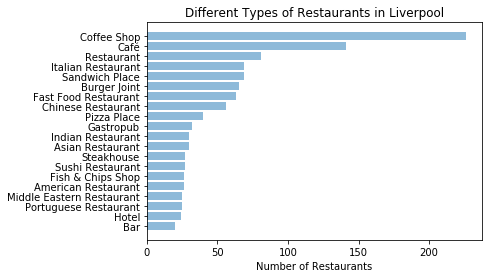

In [15]:
VenueCategory = LiverpoolVenues['Venue Category'].value_counts()
Restaurants = list(VenueCategory.index[0:20])
y_pos = np.arange(len(Restaurants))
number = VenueCategory[0:20]

plt.barh(y_pos, number, align='center', alpha=0.5)
plt.yticks(y_pos, Restaurants)
plt.xlabel('Number of Restaurants')
plt.title('Different Types of Restaurants in Liverpool')
plt.gca().invert_yaxis()

plt.rcParams['figure.figsize'] = (10, 5)
plt.show()

In [16]:
Liverpool_Onehot=pd.get_dummies(LiverpoolVenues[['Venue Category']],prefix="",prefix_sep="")
Liverpool_Onehot['Neighborhoods']=Liverpool_DF['Neighborhoods']
Fixed_Columns=[Liverpool_Onehot.columns[-1]]+list(Liverpool_Onehot.columns[:-1])
Liverpool_Onehot=Liverpool_Onehot[Fixed_Columns]

Liverpool_Grouped=Liverpool_Onehot.groupby('Neighborhoods').mean().reset_index()
Liverpool_Grouped.head()

,Neighborhoods,African Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Bistro,Brazilian Restaurant,...,Seafood Restaurant,Shawarma Place,Snack Place,Steakhouse,Sushi Restaurant,Tapas Restaurant,Tea Room,Turkish Restaurant,Vegetarian / Vegan Restaurant,Wine Bar
0,"Aigburth, St Michael's Hamlet, Sefton Park",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Aintree Village, Fazakerley",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Aintree, Fazakerley, Orrell Park, Walton",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"Allerton, Mossley Hill",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Anfield, City Centre, Everton, Fairfield, Kens...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
def return_most_common_venues(row, num_top_venues):
    row_categories=row.iloc[1:]
    row_categories_sorted=row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues=7
indicators=['st','nd','rd']

columns=['Neighborhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind])) 
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
Liverpool_Neighborhoods_Sorted=pd.DataFrame(columns=columns)
Liverpool_Neighborhoods_Sorted['Neighborhoods']=Liverpool_Grouped['Neighborhoods']

for ind in np.arange(Liverpool_Grouped.shape[0]):
    Liverpool_Neighborhoods_Sorted.iloc[ind,1:]=return_most_common_venues(Liverpool_Grouped.iloc[ind, :], num_top_venues)

Liverpool_Neighborhoods_Sorted

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,"Aigburth, St Michael's Hamlet, Sefton Park",Bagel Shop,Wine Bar,Fast Food Restaurant,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop
1,"Aintree Village, Fazakerley",Café,Wine Bar,Falafel Restaurant,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop
2,"Aintree, Fazakerley, Orrell Park, Walton",Café,Wine Bar,Falafel Restaurant,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop
3,"Allerton, Mossley Hill",Breakfast Spot,Fast Food Restaurant,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner
4,"Anfield, City Centre, Everton, Fairfield, Kens...",Coffee Shop,Cocktail Bar,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner
5,"Anfield, Everton, Kirkdale, Vauxhall",Fast Food Restaurant,Cocktail Bar,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner
6,"Anfield, Kirkdale, Walton",Gastropub,Wine Bar,Falafel Restaurant,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop
7,"Belle Vale, Gateacre, Hunts Cross, Woolton, Ha...",Chinese Restaurant,Wine Bar,Falafel Restaurant,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop
8,"Blundellsands, Brighton-le-Sands, Crosby, Litt...",Sushi Restaurant,Wine Bar,Falafel Restaurant,Coffee Shop,Coworking Space,Cupcake Shop,Deli / Bodega
9,"Bootle, Netherton",Chinese Restaurant,Wine Bar,Falafel Restaurant,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop


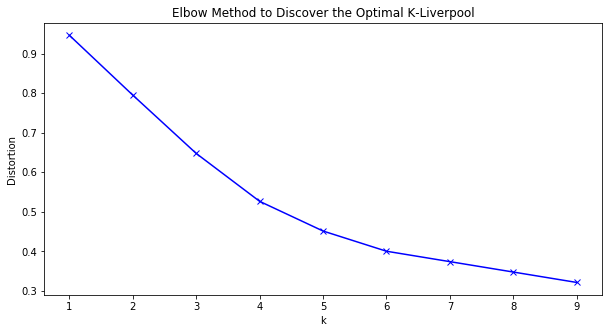

In [18]:
TestCluster=range(1,10)
Distortions=[]

Liverpool_Grouped_Clustering=Liverpool_Grouped.drop('Neighborhoods',1)

for kclusters in TestCluster:
    kmeans=KMeans(n_clusters=kclusters,random_state=0).fit(Liverpool_Grouped_Clustering)
    kmeans.fit(Liverpool_Grouped_Clustering)
    Distortions.append(sum(np.min(cdist(Liverpool_Grouped_Clustering, kmeans.cluster_centers_, 'euclidean'), axis=1)) /Liverpool_Grouped_Clustering.shape[0])
    
plt.plot(TestCluster, Distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method to Discover the Optimal K-Liverpool')
plt.show()

In [19]:
kclusters=5
kmeans=KMeans(n_clusters=kclusters, random_state=0).fit(Liverpool_Grouped_Clustering)
kmeans.labels_

Liverpool_Neighborhoods_Sorted.insert(0, 'Cluster Labels', kmeans.labels_)
Liverpool_Merged=Liverpool_DF
Liverpool_Merged=Liverpool_Merged.join(Liverpool_Neighborhoods_Sorted.set_index('Neighborhoods'), on='Neighborhoods')

Liverpool_Merged.head()

,Postcode District,Neighborhoods,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,L1,City Centre,53.395980,-2.981387,4,Café,Wine Bar,Falafel Restaurant,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop
1,L2,City Centre,53.405595,-2.993264,4,Café,Wine Bar,Falafel Restaurant,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop
2,L3,"City Centre, Everton, Vauxhall",53.415671,-3.001066,0,Pub,Wine Bar,English Restaurant,Coffee Shop,Coworking Space,Cupcake Shop,Deli / Bodega
3,L4,"Anfield, Kirkdale, Walton",53.431620,-2.963469,0,Gastropub,Wine Bar,Falafel Restaurant,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop
4,L5,"Anfield, Everton, Kirkdale, Vauxhall",53.427500,-2.969472,0,Fast Food Restaurant,Cocktail Bar,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner


#### The Five Liverpool Clusters

#### Cluster Zero:  Variety Cluster

In [20]:
Liverpool_Merged.loc[Liverpool_Merged['Cluster Labels']==0,Liverpool_Merged.columns[[1]+list(range(5, Liverpool_Merged.shape[1]))]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
2,"City Centre, Everton, Vauxhall",Pub,Wine Bar,English Restaurant,Coffee Shop,Coworking Space,Cupcake Shop,Deli / Bodega
3,"Anfield, Kirkdale, Walton",Gastropub,Wine Bar,Falafel Restaurant,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop
4,"Anfield, Everton, Kirkdale, Vauxhall",Fast Food Restaurant,Cocktail Bar,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner
11,"Croxteth Park, West Derby",Fast Food Restaurant,Cocktail Bar,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner
13,"Broadgreen, Dovecot, Knotty Ash, Page Moss",Bakery,Wine Bar,Fast Food Restaurant,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop
15,"Broadgreen, Bowring Park, Childwall",Irish Pub,Wine Bar,Falafel Restaurant,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop
16,"Aigburth, St Michael's Hamlet, Sefton Park",Bagel Shop,Wine Bar,Fast Food Restaurant,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop
17,"Allerton, Mossley Hill",Breakfast Spot,Fast Food Restaurant,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner
18,"Garston, Grassendale, Aigburth,",American Restaurant,Wine Bar,Fast Food Restaurant,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop
20,"Ford, Litherland, Seaforth",Tea Room,Wine Bar,Falafel Restaurant,Coffee Shop,Coworking Space,Cupcake Shop,Deli / Bodega


#### Cluster One:  Coffee Shops and Cocktail Bars

In [21]:
Liverpool_Merged.loc[Liverpool_Merged['Cluster Labels']==1,Liverpool_Merged.columns[[1]+list(range(5, Liverpool_Merged.shape[1]))]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
5,"Anfield, City Centre, Everton, Fairfield, Kens...",Coffee Shop,Cocktail Bar,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner
6,"City Centre, Edge Hill, Fairfield, Kensington",Coffee Shop,Cocktail Bar,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner
10,"Clubmoor, Croxteth, Gillmoss, Norris Green",Coffee Shop,Cocktail Bar,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner
12,"Clubmoor, Old Swan, Stoneycroft, Tuebrook",Coffee Shop,Cocktail Bar,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner
21,Waterloo,Coffee Shop,Cocktail Bar,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner
33,"Prescot, Knowsley Village",Coffee Shop,Cocktail Bar,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner


#### Cluster Two:  Chinese Restaurant

In [22]:
Liverpool_Merged.loc[Liverpool_Merged['Cluster Labels']==2,Liverpool_Merged.columns[[1]+list(range(5, Liverpool_Merged.shape[1]))]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
23,"Hale, Speke",Chinese Restaurant,Wine Bar,Falafel Restaurant,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop
24,"Belle Vale, Gateacre, Hunts Cross, Woolton, Ha...",Chinese Restaurant,Wine Bar,Falafel Restaurant,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop
29,"Bootle, Netherton",Chinese Restaurant,Wine Bar,Falafel Restaurant,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop
34,"Prescot, Whiston, Rainhill",Chinese Restaurant,Wine Bar,Falafel Restaurant,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop
38,"Ormskirk, Aughton",Chinese Restaurant,Wine Bar,Falafel Restaurant,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop


####  Cluster Three: Restaurants and Wine Bars

In [23]:
Liverpool_Merged.loc[Liverpool_Merged['Cluster Labels']==3,Liverpool_Merged.columns[[1]+list(range(5, Liverpool_Merged.shape[1]))]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
26,Netherley,Restaurant,Wine Bar,Coffee Shop,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop
37,"Ince Blundell, Hightown",Restaurant,Wine Bar,Coffee Shop,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop
39,"Burscough, Mawdesley, Scarisbrick, Rufford, Ho...",Restaurant,Wine Bar,Coffee Shop,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop


#### Cluster Four:  Café Cluster

In [24]:
Liverpool_Merged.loc[Liverpool_Merged['Cluster Labels']==4,Liverpool_Merged.columns[[1]+list(range(5, Liverpool_Merged.shape[1]))]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,City Centre,Café,Wine Bar,Falafel Restaurant,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop
1,City Centre,Café,Wine Bar,Falafel Restaurant,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop
7,"City Centre, Dingle, Toxteth",Café,Wine Bar,Falafel Restaurant,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop
8,"Aintree, Fazakerley, Orrell Park, Walton",Café,Wine Bar,Falafel Restaurant,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop
9,"Aintree Village, Fazakerley",Café,Wine Bar,Falafel Restaurant,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop
14,Wavertree,Café,Wine Bar,Falafel Restaurant,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop
19,"Bootle, Orrell, Kirkdale",Café,Wine Bar,Falafel Restaurant,Coworking Space,Cupcake Shop,Deli / Bodega,Dessert Shop


In [25]:
lat_lng_coords=None
while(lat_lng_coords is None):
    g=geocoder.arcgis('Liverpool, England')
    lat_lng_coords=g.latlng
    
LiverpoolLatitude=lat_lng_coords[0]
LiverpoolLongitude=lat_lng_coords[1]
LiverpoolMap=folium.Map(location=[LiverpoolLatitude, LiverpoolLongitude],zoom_start=10)

for lat, lng, neighborhood in zip(Liverpool_DF['Latitude'], Liverpool_DF['Longitude'], Liverpool_DF['Neighborhoods']):
    label='{}'.format(neighborhood)
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(LiverpoolMap)

LiverpoolMap

In [26]:
Map_Clusters_Liv=folium.Map(location=[LiverpoolLatitude, LiverpoolLongitude], zoom_start=10)

#Color Scheme
x=np.arange(kclusters)
ys=[i+x+(i+x)**2 for i in range(kclusters)]
colors_array=cm.rainbow(np.linspace(0,1,len(ys)))
rainbow=[colors.rgb2hex(i) for i in colors_array]

#Markers
markers_colors=[]
for lat, lon, poi, cluster in zip(Liverpool_Merged['Latitude'],Liverpool_Merged['Longitude'],Liverpool_Merged['Neighborhoods'],Liverpool_Merged['Cluster Labels']):
    label=folium.Popup(str(poi)+' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-2],
        fill=True,
        fill_color=rainbow[cluster-2],
        fill_opacity=1).add_to(Map_Clusters_Liv)

Map_Clusters_Liv

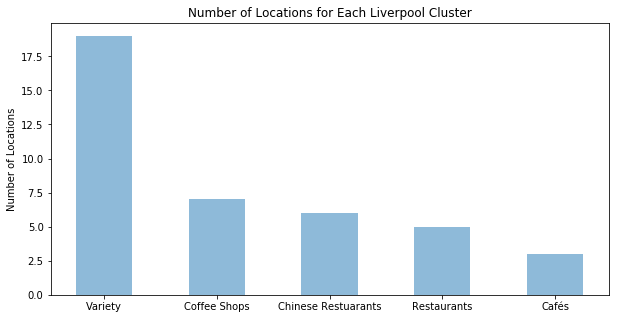

In [42]:
values = Liverpool_Merged['Cluster Labels'].value_counts()
restaurants = ['Variety',
               'Coffee Shops',
               'Chinese Restuarants',
               'Restaurants',
               'Cafés']
y_pos = np.arange(len(restaurants))
number = values[0:5]

plt.bar(y_pos, number, align='center', alpha=0.5, width=0.5)
plt.xticks(y_pos, restaurants)
plt.ylabel('Number of Locations')
plt.title('Number of Locations for Each Liverpool Cluster')

plt.show()

#### 3b.  Explore Manchester Neighborhoods

In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
    #Create the API Request
        FourSqURL='https://api.foursquare.com/v2/venues/search?&categoryId=4d4b7105d754a06374d81259&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)
    
        #Make Get Request
        try:
            results=requests.get(FourSqURL).json()['response']['venues']
        except KeyError:
            print('No Restaurant Here: {}'.format(name))
            continue;
            
        if len(results) == 0:
            print('No Restaurant Here: {}'.format(name))
        
        
        
        #Return Relevant Information
        for v in results:
            try:
                venues_list.append([(
                    name,
                    lat,
                    lng,
                    v['name'],
                    v['location']['lat'],
                    v['location']['lng'],
                    v['id'],
                    v['categories'][0]['name'])])
            except IndexError:
                print("Index Error: {}".format(v['name']))
   
    nearby_venues=pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns= [
        'Neighborhood',
        'Neighborhood Latitude',
        'Neighborhood Longitude',
        'Venue',
        'Venue Latitude',
        'Venue Longitude',
        'Venue ID',
        'Venue Category']
    
    return(nearby_venues)

ManchesterVenues=getNearbyVenues(names=Manchester_DF['Neighborhoods'], 
                                latitudes=Manchester_DF['Latitude'],
                                longitudes=Manchester_DF['Longitude'])



No Restaurant Here: Worsley, Walkden, Boothstown, Mosley Common, Wardley Industrial Estate
No Restaurant Here: Tyldesley, Astley
No Restaurant Here: Salford Quays, MediaCityUK


In [29]:
ManchesterVenues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID,Venue Category
0,"Piccadilly, City Centre, Market Street",53.481965,-2.234677,Chapter One,53.482074,-2.234863,559667a9498e4220d7f7ac59,Bookstore
1,"Piccadilly, City Centre, Market Street",53.481965,-2.234677,Foundation Coffee House,53.482305,-2.234302,555ae7b1498e8d41109dd02c,Coffee Shop
2,"Piccadilly, City Centre, Market Street",53.481965,-2.234677,Byron,53.480756,-2.236009,54eaf699498e2c090a235175,Burger Joint
3,"Piccadilly, City Centre, Market Street",53.481965,-2.234677,Cottonopolis,53.481215,-2.233464,5644e264498e304c86a6c3dd,Cocktail Bar
4,"Piccadilly, City Centre, Market Street",53.481965,-2.234677,Evelyn's Cafe Bar,53.483233,-2.235733,564e2cdd498e00839e1d15f2,Restaurant


#### Different Restaurants of Manchester

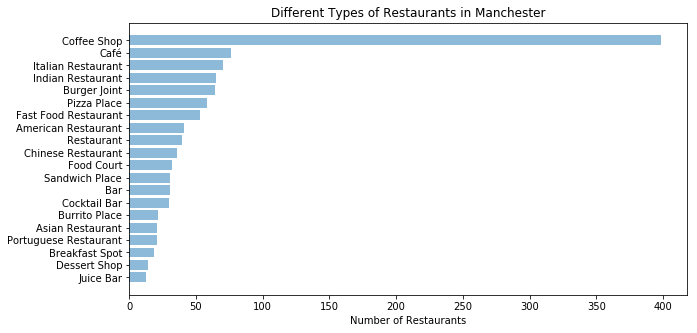

In [30]:
VenueCategory = ManchesterVenues['Venue Category'].value_counts()
Restaurants = list(VenueCategory.index[0:20])
y_pos = np.arange(len(Restaurants))
number = VenueCategory[0:20]

plt.barh(y_pos, number, align='center', alpha=0.5)
plt.yticks(y_pos, Restaurants)
plt.xlabel('Number of Restaurants')
plt.title('Different Types of Restaurants in Manchester')
plt.gca().invert_yaxis()

plt.rcParams['figure.figsize'] = (10, 5)
plt.show()

In [31]:
Manchester_Onehot=pd.get_dummies(ManchesterVenues[['Venue Category']],prefix="",prefix_sep="")
Manchester_Onehot['Neighborhoods']=Manchester_DF['Neighborhoods']
Fixed_Columns=[Manchester_Onehot.columns[-1]]+list(Manchester_Onehot.columns[:-1])
Manchester_Onehot=Manchester_Onehot[Fixed_Columns]

Manchester_Grouped=Manchester_Onehot.groupby('Neighborhoods').mean().reset_index()
Manchester_Grouped.head()

,Neighborhoods,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Bistro,...,Spanish Restaurant,Steakhouse,Sushi Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,"Abbey Hey, Gorton",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Ancoats, Northern Quarter, Strangeways",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Ardwick, Longsight, Chorlton-on-Medlock",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Atherton,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Baguley, Brooklands (Manchester and Trafford),...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories=row.iloc[1:]
    row_categories_sorted=row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues=7
indicators=['st','nd','rd']

columns=['Neighborhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind])) 
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
Manchester_Neighborhoods_Sorted=pd.DataFrame(columns=columns)
Manchester_Neighborhoods_Sorted['Neighborhoods']=Manchester_Grouped['Neighborhoods']

for ind in np.arange(Manchester_Grouped.shape[0]):
    Manchester_Neighborhoods_Sorted.iloc[ind,1:]=return_most_common_venues(Manchester_Grouped.iloc[ind, :], num_top_venues)

Manchester_Neighborhoods_Sorted

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,"Abbey Hey, Gorton",Chinese Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar,Coffee Shop,Deli / Bodega,Dessert Shop,Diner
1,"Ancoats, Northern Quarter, Strangeways",Restaurant,Vietnamese Restaurant,Chaat Place,Cocktail Bar,Coffee Shop,Deli / Bodega,Dessert Shop
2,"Ardwick, Longsight, Chorlton-on-Medlock",Coffee Shop,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar,Deli / Bodega,Dessert Shop,Diner
3,Atherton,American Restaurant,Vietnamese Restaurant,English Restaurant,Coffee Shop,Deli / Bodega,Dessert Shop,Diner
4,"Baguley, Brooklands (Manchester and Trafford),...",Burger Joint,Vietnamese Restaurant,Chinese Restaurant,Coffee Shop,Deli / Bodega,Dessert Shop,Diner
5,"Blackfriars, Greengate, Trinity",Cocktail Bar,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Deli / Bodega,Dessert Shop,Diner
6,"Carrington, Partington",American Restaurant,Vietnamese Restaurant,English Restaurant,Coffee Shop,Deli / Bodega,Dessert Shop,Diner
7,"Chorlton-cum-Hardy, Barlow Moor",Coffee Shop,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar,Deli / Bodega,Dessert Shop,Diner
8,"City Centre, Deansgate, Castlefield",Burger Joint,Vietnamese Restaurant,Chinese Restaurant,Coffee Shop,Deli / Bodega,Dessert Shop,Diner
9,"Clayton, Openshaw, Beswick",Sandwich Place,Vietnamese Restaurant,Chaat Place,Cocktail Bar,Coffee Shop,Deli / Bodega,Dessert Shop


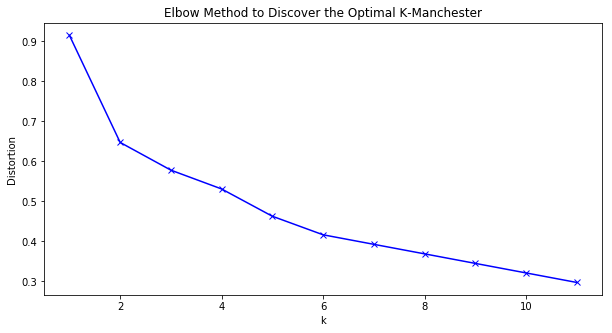

In [33]:
TestCluster=range(1,12)
Distortions=[]

Manchester_Grouped_Clustering=Manchester_Grouped.drop('Neighborhoods',1)

for kclusters in TestCluster:
    kmeans=KMeans(n_clusters=kclusters,random_state=0).fit(Manchester_Grouped_Clustering)
    kmeans.fit(Manchester_Grouped_Clustering)
    Distortions.append(sum(np.min(cdist(Manchester_Grouped_Clustering, kmeans.cluster_centers_, 'euclidean'), axis=1)) /Manchester_Grouped_Clustering.shape[0])
    
plt.plot(TestCluster, Distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method to Discover the Optimal K-Manchester')
plt.show()

In [34]:
kclusters=4
kmeans=KMeans(n_clusters=kclusters, random_state=0).fit(Manchester_Grouped_Clustering)
kmeans.labels_

Manchester_Neighborhoods_Sorted.insert(0, 'Cluster Labels', kmeans.labels_)
Manchester_Merged=Manchester_DF
Manchester_Merged=Manchester_Merged.join(Manchester_Neighborhoods_Sorted.set_index('Neighborhoods'), on='Neighborhoods')

Manchester_Merged

,Postcode District,Neighborhoods,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,M1,"Piccadilly, City Centre, Market Street",53.481965,-2.234677,0,Bookstore,Chinese Restaurant,Coffee Shop,Deli / Bodega,Dessert Shop,Diner,Dive Bar
1,M2,"Deansgate, City Centre",53.481730,-2.242310,1,Coffee Shop,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar,Deli / Bodega,Dessert Shop,Diner
2,"M3(Sectors 1, 2, 3, 4 and 9)","City Centre, Deansgate, Castlefield",53.400416,-2.241279,2,Burger Joint,Vietnamese Restaurant,Chinese Restaurant,Coffee Shop,Deli / Bodega,Dessert Shop,Diner
3,"M3(Sectors 5, 6 and 7)","Blackfriars, Greengate, Trinity",53.438762,-2.319094,0,Cocktail Bar,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Deli / Bodega,Dessert Shop,Diner
4,M4,"Ancoats, Northern Quarter, Strangeways",53.483910,-2.236616,0,Restaurant,Vietnamese Restaurant,Chaat Place,Cocktail Bar,Coffee Shop,Deli / Bodega,Dessert Shop
5,M5,"Ordsall, Seedley, Weaste, University",53.471845,-2.276101,0,Lounge,Vietnamese Restaurant,Fried Chicken Joint,Cocktail Bar,Coffee Shop,Deli / Bodega,Dessert Shop
6,M6,"Pendleton, Irlams o' th' Height, Langworthy, S...",53.498285,-2.287012,0,Indian Restaurant,Vietnamese Restaurant,Donut Shop,Cocktail Bar,Coffee Shop,Deli / Bodega,Dessert Shop
7,M7,"Higher Broughton, Cheetwood, Lower Broughton, ...",53.492050,-2.261105,0,Italian Restaurant,Vietnamese Restaurant,Donut Shop,Cocktail Bar,Coffee Shop,Deli / Bodega,Dessert Shop
8,M8,"Crumpsall, Cheetham Hill",53.503530,-2.239864,1,Coffee Shop,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar,Deli / Bodega,Dessert Shop,Diner
9,M9,"Harpurhey, Blackley",53.535010,-2.231018,0,Portuguese Restaurant,Vietnamese Restaurant,Chaat Place,Cocktail Bar,Coffee Shop,Deli / Bodega,Dessert Shop


####  Cluster Zero: Variety

In [35]:
Manchester_Merged.loc[Manchester_Merged['Cluster Labels']==0,Manchester_Merged.columns[[1]+list(range(5, Manchester_Merged.shape[1]))]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,"Piccadilly, City Centre, Market Street",Bookstore,Chinese Restaurant,Coffee Shop,Deli / Bodega,Dessert Shop,Diner,Dive Bar
3,"Blackfriars, Greengate, Trinity",Cocktail Bar,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Deli / Bodega,Dessert Shop,Diner
4,"Ancoats, Northern Quarter, Strangeways",Restaurant,Vietnamese Restaurant,Chaat Place,Cocktail Bar,Coffee Shop,Deli / Bodega,Dessert Shop
5,"Ordsall, Seedley, Weaste, University",Lounge,Vietnamese Restaurant,Fried Chicken Joint,Cocktail Bar,Coffee Shop,Deli / Bodega,Dessert Shop
6,"Pendleton, Irlams o' th' Height, Langworthy, S...",Indian Restaurant,Vietnamese Restaurant,Donut Shop,Cocktail Bar,Coffee Shop,Deli / Bodega,Dessert Shop
7,"Higher Broughton, Cheetwood, Lower Broughton, ...",Italian Restaurant,Vietnamese Restaurant,Donut Shop,Cocktail Bar,Coffee Shop,Deli / Bodega,Dessert Shop
9,"Harpurhey, Blackley",Portuguese Restaurant,Vietnamese Restaurant,Chaat Place,Cocktail Bar,Coffee Shop,Deli / Bodega,Dessert Shop
10,"Clayton, Openshaw, Beswick",Sandwich Place,Vietnamese Restaurant,Chaat Place,Cocktail Bar,Coffee Shop,Deli / Bodega,Dessert Shop
15,"Firswood, Old Trafford, Whalley Range, Moss Side",Breakfast Spot,Vietnamese Restaurant,Chinese Restaurant,Coffee Shop,Deli / Bodega,Dessert Shop,Diner
17,"Abbey Hey, Gorton",Chinese Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar,Coffee Shop,Deli / Bodega,Dessert Shop,Diner


#### Cluster One: Coffee Shops and Vietnamese

In [36]:
Manchester_Merged.loc[Manchester_Merged['Cluster Labels']==1,Manchester_Merged.columns[[1]+list(range(5, Manchester_Merged.shape[1]))]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
1,"Deansgate, City Centre",Coffee Shop,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar,Deli / Bodega,Dessert Shop,Diner
8,"Crumpsall, Cheetham Hill",Coffee Shop,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar,Deli / Bodega,Dessert Shop,Diner
11,"Ardwick, Longsight, Chorlton-on-Medlock",Coffee Shop,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar,Deli / Bodega,Dessert Shop,Diner
12,"Ardwick, Longsight, Chorlton-on-Medlock",Coffee Shop,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar,Deli / Bodega,Dessert Shop,Diner
13,"Fallowfield, Moss Side, Ladybarn, Rusholme, Vi...",Coffee Shop,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar,Deli / Bodega,Dessert Shop,Diner
14,"Hulme, Manchester Science Park, Old Trafford",Coffee Shop,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar,Deli / Bodega,Dessert Shop,Diner
18,"Levenshulme, Burnage",Coffee Shop,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar,Deli / Bodega,Dessert Shop,Diner
19,"Didsbury, Withington",Coffee Shop,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar,Deli / Bodega,Dessert Shop,Diner
20,"Chorlton-cum-Hardy, Barlow Moor",Coffee Shop,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar,Deli / Bodega,Dessert Shop,Diner
23,"Middleton, Alkrington, Chadderton",Coffee Shop,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar,Deli / Bodega,Dessert Shop,Diner


#### Cluster Two:  Burger Joints

In [37]:
Manchester_Merged.loc[Manchester_Merged['Cluster Labels']==2,Manchester_Merged.columns[[1]+list(range(5, Manchester_Merged.shape[1]))]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
2,"City Centre, Deansgate, Castlefield",Burger Joint,Vietnamese Restaurant,Chinese Restaurant,Coffee Shop,Deli / Bodega,Dessert Shop,Diner
22,"Baguley, Brooklands (Manchester and Trafford),...",Burger Joint,Vietnamese Restaurant,Chinese Restaurant,Coffee Shop,Deli / Bodega,Dessert Shop,Diner
37,"Urmston, Davyhulme, Flixton, Trafford Park",Burger Joint,Vietnamese Restaurant,Chinese Restaurant,Coffee Shop,Deli / Bodega,Dessert Shop,Diner


#### Cluster Three:  Pizza Place

In [38]:
Manchester_Merged.loc[Manchester_Merged['Cluster Labels']==3,Manchester_Merged.columns[[1]+list(range(5, Manchester_Merged.shape[1]))]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
16,"Trafford Park, The Trafford Centre",Pizza Place,Vietnamese Restaurant,Chaat Place,Cocktail Bar,Coffee Shop,Deli / Bodega,Dessert Shop
26,"Swinton, Clifton, Pendlebury, Wardley, Agecroft",Pizza Place,Vietnamese Restaurant,Chaat Place,Cocktail Bar,Coffee Shop,Deli / Bodega,Dessert Shop


#### Mapping Each Cluster

In [39]:
lat_lng_coords=None
while(lat_lng_coords is None):
    g=geocoder.arcgis('Manchester, England')
    lat_lng_coords=g.latlng
    
ManchesterLatitude=lat_lng_coords[0]
ManchesterLongitude=lat_lng_coords[1]
ManchesterMap=folium.Map(location=[ManchesterLatitude, ManchesterLongitude],zoom_start=10)

for lat, lng, neighborhood in zip(Manchester_DF['Latitude'], Manchester_DF['Longitude'], Manchester_DF['Neighborhoods']):
    label='{}'.format(neighborhood)
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(ManchesterMap)

ManchesterMap

In [40]:
Map_Clusters=folium.Map(location=[ManchesterLatitude, ManchesterLongitude], zoom_start=10)

#Color Scheme
x=np.arange(kclusters)
ys=[i+x+(i+x)**2 for i in range(kclusters)]
colors_array=cm.rainbow(np.linspace(0,1,len(ys)))
rainbow=[colors.rgb2hex(i) for i in colors_array]

#Markers
markers_colors=[]
for lat, lon, poi, cluster in zip(Manchester_Merged['Latitude'],Manchester_Merged['Longitude'],Manchester_Merged['Neighborhoods'],Manchester_Merged['Cluster Labels']):
    label=folium.Popup(str(poi)+' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-2],
        fill=True,
        fill_color=rainbow[cluster-2],
        fill_opacity=1).add_to(Map_Clusters)

Map_Clusters

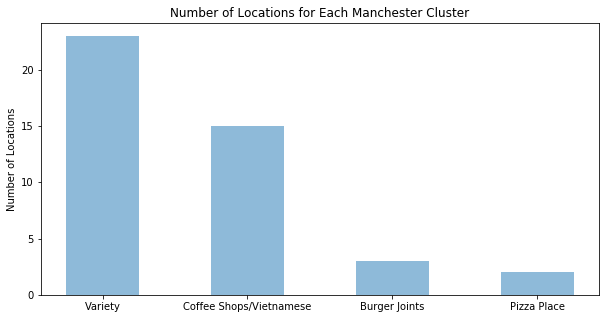

In [43]:

values = Manchester_Merged['Cluster Labels'].value_counts()
restaurants = ['Variety',
               'Coffee Shops/Vietnamese',
               'Burger Joints',
               'Pizza Place']
y_pos = np.arange(len(restaurants))
number = values[0:4]

plt.bar(y_pos, number, align='center', alpha=0.5, width=0.5)
plt.xticks(y_pos, restaurants)
plt.ylabel('Number of Locations')
plt.title('Number of Locations for Each Manchester Cluster')

plt.show()